Training frames extracted.
Descriptors vstacked.
Descriptors clustered.
Image features extracted.
Training frames normalized.


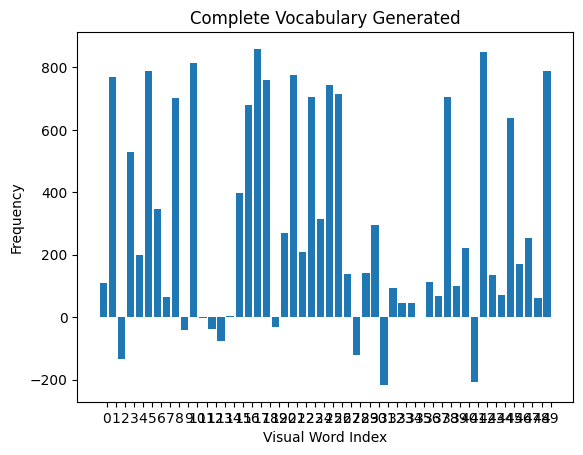

Features histogram plotted.
SVM fitted.
Training completed.
Testing frames extracted.


IndexError: invalid index to scalar variable.

In [9]:
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode

# Paths specified directly in the code
TRAIN_PATH = r'D:\Academics\7th SEMESTER\DLCV\final_dataset'
TEST_PATH = r'D:\Academics\7th SEMESTER\DLCV\final_dataset'
NO_CLUSTERS = 50
KERNEL_TYPE = "linear"

def saveFrames(video_path, output_folder, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (150, 150))
            
            # Save each frame
            frame_filename = os.path.join(output_folder, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frames.append(frame)
            
        frame_count += 1
    cap.release()
    return saved_frames

def getFramesFromVideo(video_path, frame_interval=5):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            frame = cv2.resize(frame, (150, 150))  # Resize for consistency
            frames.append(frame)
        frame_count += 1
    cap.release()
    return frames

def getFiles(train, path, frame_interval=5):
    videos = []
    labels = []
    for file in os.listdir(path):
        if file.endswith(".mp4"):  # Assuming videos are in .mp4 format
            label = int(file.split("_")[-1][0])  # Extract label based on filename
            video_path = os.path.join(path, file)
            
            # Create an output folder for saving frames
            output_folder = os.path.join('extracted_frames', f"{file}_{label}")
            os.makedirs(output_folder, exist_ok=True)
            
            # Extract and save frames
            frames = saveFrames(video_path, output_folder, frame_interval)
            videos.extend(frames)
            labels.extend([label] * len(frames))
    return videos, labels

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0], dtype=np.float64)
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor.astype(np.float64)))  # Ensure dtype is float64
    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters=no_clusters, n_init=10).fit(descriptors.astype(np.float64))
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.zeros((image_count, no_clusters), dtype=np.float32)
    for i in range(image_count):
        if descriptor_list[i] is not None:
            for descriptor in descriptor_list[i]:
                idx = kmeans.predict([descriptor.astype(np.float64)])
                im_features[i][idx] += 1
    return im_features

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([np.sum(im_features[:, i], dtype=np.int32) for i in range(no_clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    param_grid = {'C': [0.5, 0.1, 0.15, 0.2, 0.3], 'gamma': [0.1, 0.11, 0.095, 0.105]}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if kernel == "precomputed":
        features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params["C"], params["gamma"]
    class_weight = {i: len(train_labels) / (7 * np.bincount(train_labels)[i]) for i in range(len(np.unique(train_labels)))}
  
    svm = SVC(kernel=kernel, C=C_param, gamma=gamma_param, class_weight=class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        title = 'Normalized confusion matrix' if normalize else 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes,
           title=title, ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    class_names = ["armflapping", "headbanging", "spinning"]
    plotConfusionMatrix(true, predictions, classes=class_names, title='Confusion matrix, without normalization')
    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

def findAccuracy(true, predictions):
    print('Accuracy score: %0.3f' % accuracy_score(true, predictions))

def trainModel(path, no_clusters, kernel):
    frames, labels = getFiles(True, path)
    print("Training frames extracted.")
    
    sift = cv2.SIFT_create()
    descriptor_list = []
    train_labels = np.array(labels)
    image_count = len(frames)

    for frame in frames:
        des = getDescriptors(sift, frame)
        if des is not None:
            descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Image features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Training frames normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel, frame_interval=5):
    frames, true_labels = getFiles(False, path, frame_interval)
    print("Testing frames extracted.")
    
    descriptor_list = []
    for frame in frames:
        des = getDescriptors(cv2.SIFT_create(), frame)
        if des is not None:
            descriptor_list.append(des)
        else:
            print("No descriptors found for a frame.")

    # Check if descriptor_list is empty
    if not descriptor_list:
        print("No descriptors were extracted from the test frames. Exiting test.")
        return

    descriptors = vstackDescriptors(descriptor_list)
    
    test_features = extractFeatures(kmeans, descriptor_list, len(frames), no_clusters)
    test_features = scale.transform(test_features)

    if kernel == "precomputed":
        test_features = np.dot(test_features, im_features.T)
    
    predictions = svm.predict(test_features)

    # Handle the predictions safely
    if len(predictions) == 0:
        print("No predictions were made.")
        return

    # Use mode to get the most common prediction
    mode_result = mode(predictions)
    final_predictions = mode_result.mode[0] if mode_result.count[0] > 0 else predictions[0]

    print(f"Final predicted label: {final_predictions}")

    findAccuracy(true_labels, predictions)
    print("Accuracy calculated.")
    print("Testing completed.")


def execute():
    kmeans, scale, svm, im_features = trainModel(TRAIN_PATH, NO_CLUSTERS, KERNEL_TYPE)
    testModel(TEST_PATH, kmeans, scale, svm, im_features, NO_CLUSTERS, KERNEL_TYPE)
    print("Execution completed.")
    
execute()